In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")

Loading the low res data. 

In [3]:
KIDID = "01"
#datadir = "/home/tangq/Downloads/20180914/KID_K0" + KIDID +"/Set_Temperature_010_mK/Set_Attenuation_20p0dB/"
datadir = "/Users/amytang/"
hdulist = fits.open(datadir + "Sweep.fits")
data = hdulist[1].data
freq = data.field(0)
I = data.field(1)
Q = data.field(2)
amp = np.sqrt(I**2 + Q**2)
phase = np.arctan2(Q,I)
savedir = "/Users/amytang/KID_K0" + KIDID + "_"

Getting the off resonance part of sweep and checking to make sure it looks okay

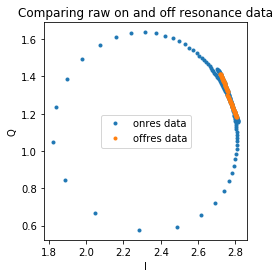

In [5]:
figonoff = plt.figure()
plt.plot(I,Q,'.',label='onres data')
fresindex = np.where(amp==min(amp))[0][0]
offmargin = int(len(amp)/4)
Ioffres = np.concatenate((I[10:fresindex-offmargin],I[fresindex+offmargin:-10]))
Qoffres = np.concatenate((Q[10:fresindex-offmargin],Q[fresindex+offmargin:-10]))
foffres = np.concatenate((freq[10:fresindex-offmargin],freq[fresindex+offmargin:-10]))
plt.plot(Ioffres,Qoffres,'.', label='offres data')
plt.xlabel('I')
plt.ylabel('Q')
plt.legend(loc='best')
plt.title('Comparing raw on and off resonance data')
plt.gca().set_aspect('equal')
plt.show()
pdf.savefig(figonoff)
plt.close()

Getting the electronic delay $\tau$ with the latter half of the off resonance data and fitting the phase as a straight line

1.2127627490909438e-07 486.1264014909617


<Figure size 432x288 with 0 Axes>

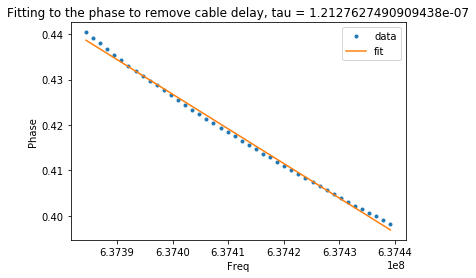

In [6]:
#getting the latter half of the offresonance data
fresindex = np.where(amp==min(amp))[0][0]
Ioffres = I[fresindex+offmargin:-10]
Qoffres = Q[fresindex+offmargin:-10]
foffres = freq[fresindex+offmargin:-10]
phaseoffres = np.arctan2(Qoffres,Ioffres)
plt.plot(foffres,phaseoffres,'.')

#doing fits
from scipy.optimize import curve_fit, least_squares

def phase(x, a,b):
    y = -2.*np.pi*x*a+b
    return y
popt, pcov = curve_fit(phase, foffres, phaseoffres, bounds=((1.e-8,-np.inf),(1.e-6,np.inf)))
print (popt[0],popt[1])
tau = popt[0]
#plotting the fit and data

plt.clf()
figcabledelay =  plt.figure()
plt.plot(foffres, phaseoffres,'.',label='data')
plt.plot(foffres, -2*np.pi*foffres*popt[0]+popt[1], label='fit')
plt.legend()
plt.xlabel('Freq')
plt.ylabel('Phase')
plt.title('Fitting to the phase to remove cable delay, tau = ' + str(tau))
pdf.savefig(figcabledelay)
plt.show()
plt.close()

Removing cable delay from data by multiplying $e^{2\pi jf \tau}$, the off resonance tails should now map to a dot

<Figure size 432x288 with 0 Axes>

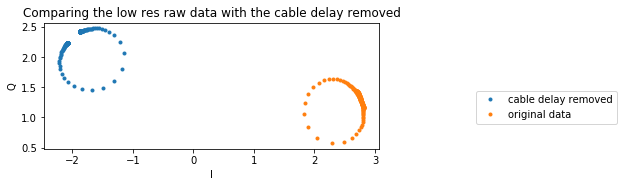

In [7]:
data1 = (I+1.j*Q)*np.exp(1.j*2.*np.pi*freq*popt[0])
plt.clf()
fignocabledelay = plt.figure()
plt.plot(data1.real, data1.imag,'.', label='cable delay removed')
plt.plot(I,Q,'.',label='original data')
plt.gca().set_aspect('equal')
plt.xlabel('I')
plt.ylabel('Q')
plt.title('Comparing the low res raw data with the cable delay removed')
plt.legend(loc=9, bbox_to_anchor=(1.5, 0.5))

pdf.savefig(fignocabledelay)
plt.show()
plt.close()

Loading the high resolution data and comparing to low resolution data with and without cable delay (sanity check).

<Figure size 432x288 with 0 Axes>

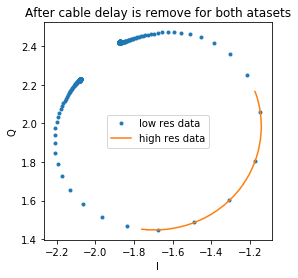

In [8]:
#plotting raw data of both HR and LR data
hdulist = fits.open(datadir + "Sweep_HR.fits")
datahr = hdulist[1].data
freqhr = np.zeros((len(datahr)))
Ihr = np.zeros((len(datahr)))
Qhr = np.zeros((len(datahr)))
for i in range(len(datahr)):
    freqhr[i] = np.asarray(datahr[i])[0]
    Ihr[i] = np.asarray(datahr[i])[1]
    Qhr[i] = np.asarray(datahr[i])[2]
amphr = np.sqrt(Ihr**2 + Qhr**2)
phasehr = np.arctan2(Qhr,Ihr)
plt.clf()
figlrhr = plt.figure()
plt.plot(Ihr,Qhr,'.',label='raw HR data')
plt.plot(I,Q,'.', label='raw LR data')
plt.ylabel('Q')
plt.xlabel('I')
plt.legend(loc='best')
plt.gca().set_aspect('equal')

plt.title('Comparing the RAW HR and LR data, making sure they overlap')

pdf.savefig(figlrhr)
plt.close()


#removing cable delay for both data
sweepdatahr = Ihr+1.j*Qhr
datahr1 = sweepdatahr*np.exp(1.j*2.*np.pi*freqhr*tau)#-popt[1])
plt.clf()
figlrhrncd = plt.figure()
Ihr1 = datahr1.real
Qhr1 = datahr1.imag
plt.plot(data1.real, data1.imag,'.', label='low res data')
plt.plot(Ihr1,Qhr1, label='high res data')
plt.xlabel('I')
plt.ylabel('Q')
plt.legend(loc='best')
plt.title('After cable delay is remove for both atasets')
plt.gca().set_aspect('equal')

pdf.savefig(figlrhrncd)
#plt.close()

Doing circle fitting with least squares

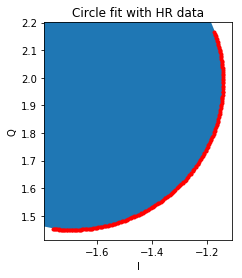

In [9]:
from scipy import optimize
def calc_R(xc,yc):
    return np.sqrt((Ihr1-xc)**2+(Qhr1-yc)**2)

def f_2(c):
    Ri = calc_R(*c)
    return Ri- Ri.mean()

center_estimate = np.mean([max(Ihr1), min(Ihr1)]), np.mean([max(Qhr1), min(Qhr1)])
center_2, ier = optimize.leastsq(f_2,center_estimate)

xc_2, yc_2 = center_2
Ri_2 = calc_R(*center_2)
R_2 = Ri_2.mean()
residu_2 = sum((Ri_2-R_2)**2)

#Plotting fit and the data
circle1 = plt.Circle((xc_2,yc_2), R_2)
fig, ax=plt.subplots()
ax.add_artist((circle1))
ax.plot(Ihr1,Qhr1,'.', color='r', label='Data')
ax.set_aspect('equal')
ax.set_ylabel('Q')
ax.set_xlabel('I')
ax.set_title('Circle fit with HR data')
pdf.savefig(fig)


Rotating and translating the circle via equation E.10 from Gao

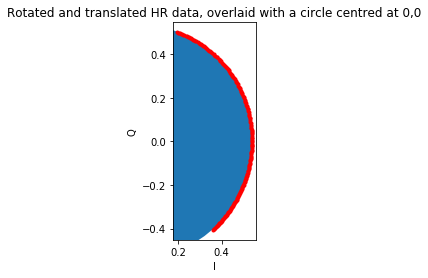

In [10]:
zc = xc_2 + 1.j*yc_2
alpha = np.angle(zc)
datahr2 = (zc-datahr1)*np.exp(-1.j*alpha)
Ihr2 = datahr2.real
Qhr2 = datahr2.imag

#plotting
circle2 = plt.Circle((0,0), R_2)
fig2, ax2=plt.subplots()
ax2.add_artist((circle2))
ax2.plot(Ihr2,Qhr2,'.',color='r',label='data')
ax2.set_aspect('equal')
ax2.set_ylabel('Q')
ax2.set_xlabel('I')
ax2.set_title('Rotated and translated HR data, overlaid with a circle centred at 0,0')
pdf.savefig(fig2)


Phase angle fit via eqn E.11 from Gao

-0.5462628080283493 58424.63596139792 637319348.7755055


<Figure size 432x288 with 0 Axes>

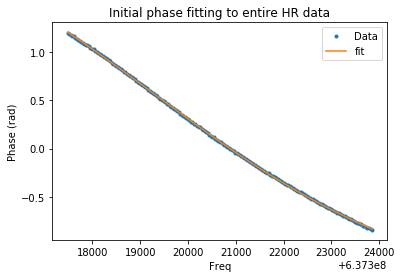

In [11]:

def phasefit(x, a, b, c):
    y = -a + 2*np.arctan(2*b*(1-(x/c)))
    return y
phasehr2 = np.arctan2(Qhr2,Ihr2)
popt, pcov = curve_fit(phasefit, freqhr, phasehr2, bounds=((-3, 1.e4,min(freqhr)),(3, 5.e6,max(freqhr))))
theta0,Qr,fr = popt[0], popt[1], popt[2]

#plotting
print (theta0,Qr,fr)
plt.clf()
figphasefit1 = plt.figure()
plt.plot(freqhr,phasehr2,'.', label='Data')
plt.plot(freqhr, phasefit(freqhr, theta0, Qr, fr), label='fit')
plt.legend()
plt.xlabel('Freq')
plt.ylabel('Phase (rad)')
plt.title('Initial phase fitting to entire HR data')
pdf.savefig(figphasefit1)
plt.show()
plt.close()

Trying to fit to less data (optional, only if above fails)

In [28]:
popt, pcov = curve_fit(phasefit, freqhr[150:-150], phasehr2[150:-150], bounds=((-3, 1.e4,min(freqhr)),(3, 5.e6,max(freqhr))))
theta0,Qr,fr = popt[0], popt[1], popt[2]

print (theta0,Qr,fr)
plt.clf()
figphasefit2 = plt.figure()
plt.plot(freqhr,phasehr2,'.', label='Data')
plt.plot(freqhr, phasefit(freqhr, theta0, Qr, fr), label='fit')
plt.legend()
plt.xlabel('Freq')
plt.ylabel('Phase (rad)')
plt.title('Fitting to the middle 100 points')
pdf.savefig(figphasefit2)
plt.show()
plt.close()

ValueError: On entry to DGESDD parameter number 5 had an illegal value

Loading timestream data

<Figure size 432x288 with 0 Axes>

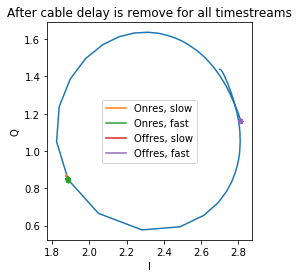

<Figure size 432x288 with 0 Axes>

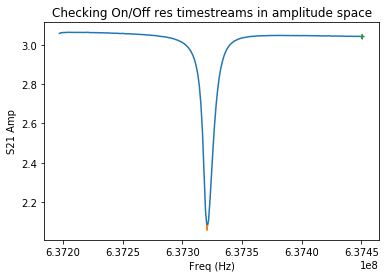

(10000, 20) (40000, 12)


In [4]:
hdulist = fits.open(datadir + "TS_200000_Hz_OFF_RES_x020.fits")
freqoff = hdulist[1].header['SYNTHFRE']
data_off1 = hdulist[1].data
Ioff1 = np.zeros((len(data_off1.field(0)),20))
Qoff1 = np.zeros((len(data_off1.field(1)),20))
for i in range(20):
    Ioff1[:,i] = data_off1.field(i*2)
    Qoff1[:,i] = data_off1.field(i*2+1)
hdulist = fits.open(datadir + "TS_200000_Hz_ON_RES_x020.fits")
data_on1 = hdulist[1].data
freqon = hdulist[1].header['SYNTHFRE']
Ion1 = np.zeros((len(data_on1.field(0)),20))
Qon1 = np.zeros((len(data_on1.field(1)),20))
for i in range(20):
    Ion1[:,i] = data_on1.field(i*2)
    Qon1[:,i] = data_on1.field(i*2+1)
hdulist = fits.open(datadir + "TS_2000_Hz_OFF_RES_x012.fits")
data_off2 = hdulist[1].data
Ioff2 = np.zeros((len(data_off2.field(0)),12))
Qoff2 = np.zeros((len(data_off2.field(1)),12))
for i in range(12):
    Ioff2[:,i] = data_off2.field(i*2)
    Qoff2[:,i] = data_off2.field(i*2+1)
hdulist = fits.open(datadir + "TS_2000_Hz_ON_RES_x012.fits")
data_on2 = hdulist[1].data
Ion2 = np.zeros((len(data_on2.field(0)),12))
Qon2 = np.zeros((len(data_on2.field(1)),12))
for i in range(12):
    Ion2[:,i] = data_on2.field(i*2)
    Qon2[:,i] = data_on2.field(i*2+1)
Ion1f = Ion1.flatten()
Qon1f = Qon1.flatten()
Ion2f = Ion2.flatten()
Qon2f = Qon2.flatten()
Ioff1f = Ioff1.flatten()
Qoff1f = Qoff1.flatten()
Ioff2f = Ioff2.flatten()
Qoff2f = Qoff2.flatten()
# for i in range(12):
#     plt.plot(Ion2[:,i])
#     plt.plot(Qon2[:,i])
#plt.xlim(4000,5000)
plt.figure()

plt.clf()
figalltimestream = plt.figure()
plt.plot(I,Q)
plt.plot(Ion2f,Qon2f,label='Onres, slow')
plt.plot(Ion1f,Qon1f,label='Onres, fast')
plt.plot(Ioff2f,Qoff2f,label='Offres, slow')
plt.plot(Ioff1f,Qoff1f,label='Offres, fast')
plt.xlabel('I')
plt.ylabel('Q')
plt.legend(loc='best')
plt.title('After cable delay is remove for all timestreams')
plt.gca().set_aspect('equal')
plt.show()
#pdf.savefig(figalltimestream)
plt.close()

plt.clf()
figamp = plt.figure()
plt.plot(freq,amp)
plt.plot(np.ones(len(Ion1f))*freqon, np.sqrt(Ion1f**2+Qon1f**2))
plt.plot(np.ones(len(Ioff1f))*freqoff, np.sqrt(Ioff1f**2+Qoff1f**2))
plt.xlabel('Freq (Hz)')
plt.ylabel('S21 Amp')
plt.title('Checking On/Off res timestreams in amplitude space')
plt.show()
#pdf.savefig(figamp)
plt.close()
print (Ion1.shape, Ion2.shape)

<Figure size 432x288 with 0 Axes>

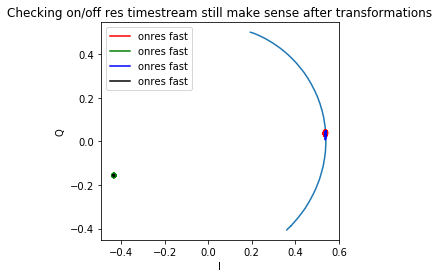

In [13]:
#applying transformations to the timestreams and checking:
tson1 = Ion1+1.j*Qon1
tson2 = Ion2+1.j*Qon2
tsoff1 = Ioff1+1.j*Qoff1
tsoff2 = Ioff2+1.j*Qoff2
# removing cable delay 
tson1_1 = tson1*np.exp(1.j*2.*np.pi*freqon*tau)
tson2_1 = tson2*np.exp(1.j*2.*np.pi*freqon*tau)
tsoff1_1 = tsoff1*np.exp(1.j*2.*np.pi*freqoff*tau)
tsoff2_1 = tsoff2*np.exp(1.j*2.*np.pi*freqoff*tau)
#rotating and translating the circle
tson1_2 = (zc-tson1_1)*np.exp(-1.j*alpha)
tson2_2 = (zc-tson2_1)*np.exp(-1.j*alpha)
tsoff1_2 = (zc-tsoff1_1)*np.exp(-1.j*alpha)
tsoff2_2 = (zc-tsoff2_1)*np.exp(-1.j*alpha)

#plotting
plt.clf()
figmodts = plt.figure()
plt.plot(Ihr2,Qhr2)
for i in range(20):
    plt.plot(tson1_2[:,i].real,tson1_2[:,i].imag, color='r')
    plt.plot(tsoff1_2[:,i].real,tsoff1_2[:,i].imag, color='g')
plt.plot(tson1_2[:,i].real,tson1_2[:,i].imag, color='r',label='onres fast')
plt.plot(tsoff1_2[:,i].real,tsoff1_2[:,i].imag, color='g', label='onres fast')
for i in range(12):
    plt.plot(tson2_2[:,i].real,tson2_2[:,i].imag, color = 'b')
    plt.plot(tsoff2_2[:,i].real,tsoff2_2[:,i].imag, color='k')
plt.plot(tson2_2[:,i].real,tson2_2[:,i].imag, color = 'b',label='onres fast')
plt.plot(tsoff2_2[:,i].real,tsoff2_2[:,i].imag, color='k',label='onres fast')
plt.gca().set_aspect('equal')
plt.legend(loc='best')
plt.ylabel('Q')
plt.xlabel('I')
plt.title('Checking on/off res timestream still make sense after transformations')
plt.show()
#pdf.savefig(figmodts)
plt.close()


<Figure size 432x288 with 0 Axes>

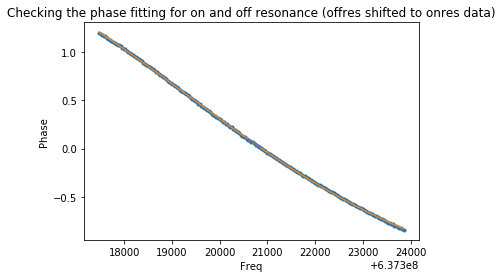

In [14]:


def freqfit(x, a, b, c):
    y = c*(1.-(1./(2*b))*np.tan((x+a)/2.))
    return y



#moving the IQ noiseball off resonance to where on resonance is
avg_on1 = np.mean(tson1_2.real) +1.j*np.mean(tson1_2.imag) 
avg_on2 = np.mean(tson2_2.real) +1.j*np.mean(tson2_2.imag)
avg_off1 = np.mean(tsoff1_2.real)+1.j*np.mean(tsoff1_2.imag)
avg_off2 = np.mean(tsoff2_2.real) + 1.j*np.mean(tsoff2_2.imag)
tsoff1_3 = tsoff1_2 - avg_off1 + avg_on1
tsoff2_3 = tsoff2_2 - avg_off2 + avg_on2


phase_on1 = np.zeros((tson1_2.shape))
phase_on2 = np.zeros((tson2_2.shape))
phase_off1 = np.zeros((tsoff1_3.shape))
phase_off2 = np.zeros((tsoff2_3.shape))
freq_on1 = np.zeros((phase_on1.shape))
freq_on2 = np.zeros((phase_on2.shape))
freq_off1 = np.zeros((phase_off1.shape))
freq_off2 = np.zeros((phase_off2.shape))


for i in range(20):
    phase_on1[:,i] = np.arctan2(tson1_2[:,i].imag,tson1_2[:,i].real)
    phase_off1[:,i] = np.arctan2(tsoff1_3[:,i].imag,tsoff1_3[:,i].real)
    freq_on1[:,i] = freqfit(phase_on1[:,i], theta0, Qr, fr)
    freq_off1[:,i] = freqfit(phase_off1[:,i], theta0, Qr, fr)
    
for i in range(12):
    phase_on2[:,i] = np.arctan2(tson2_2[:,i].imag,tson2_2[:,i].real)
    phase_off2[:,i] = np.arctan2(tsoff2_3[:,i].imag,tsoff2_3[:,i].real)
    freq_on2[:,i] = freqfit(phase_on2[:,i], theta0, Qr, fr)
    freq_off2[:,i] = freqfit(phase_off2[:,i], theta0, Qr, fr)

plt.clf()
figphasecheck = plt.figure()
plt.plot(freqhr,phasehr2,'.', label='Data')
plt.plot(freqhr, phasefit(freqhr, theta0, Qr, fr), label='fit')
for i in range(20):
    plt.plot(freq_on1[:,i], phase_on1[:,i])
    plt.plot(freq_off1[:,i], phase_off1[:,i])
for i in range(12):
    plt.plot(freq_on2[:,i], phase_on2[:,i])
    plt.plot(freq_off2[:,i], phase_off2[:,i])
plt.xlabel('Freq')
plt.ylabel('Phase')
plt.title('Checking the phase fitting for on and off resonance (offres shifted to onres data)')
#pdf.savefig(figphasecheck)
plt.show()

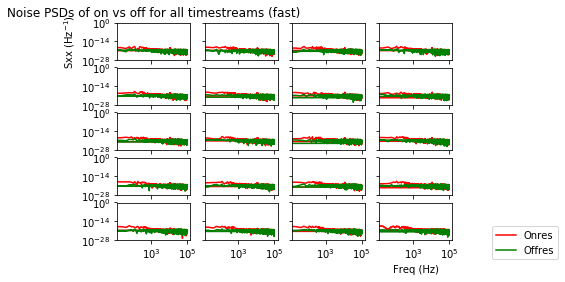

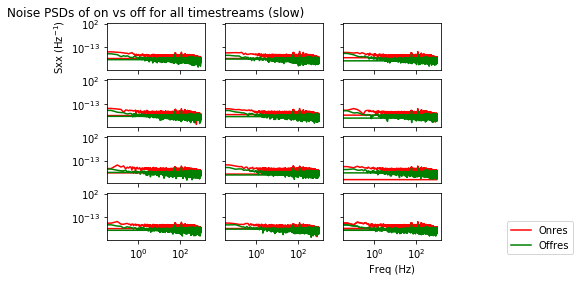

In [16]:
sr1 = 200000.
sr2 = 2000.
psd_on1 = np.zeros((freq_on1.shape))
psd_on2 = np.zeros((freq_on2.shape))
psd_off1 = np.zeros((freq_off1.shape))
psd_off2 = np.zeros((freq_off2.shape))

psd_onfreq1 = np.fft.fftfreq(len(freq_on1[:,0]), d=1./sr1)
psd_onfreq2 = np.fft.fftfreq(len(freq_on2[:,0]), d=1./sr2)
psd_offfreq1 = np.fft.fftfreq(len(freq_off1[:,0]), d=1./sr1)
psd_offfreq2 = np.fft.fftfreq(len(freq_off2[:,0]), d=1./sr2)

figpsd1, axarr1 = plt.subplots(5, 4,sharex=True, sharey=True)
for i in range(20):
    psd_on1[:,i] = abs(np.fft.fft(freq_on1[:,i]))**2/(len(freq_on1[:,i])*sr1)/freqon**2
    psd_off1[:,i] = abs(np.fft.fft(freq_off1[:,i]))**2/(len(freq_off1[:,i])*sr1)/freqoff**2
    axarr1[int(i/4), i % 4].plot(psd_onfreq1, psd_on1[:,i], color='r')
    axarr1[int(i/4), i % 4].plot(psd_offfreq1, psd_off1[:,i], color = 'g')
axarr1[int(i/4), i % 4].plot(psd_onfreq1, psd_on1[:,i], color='r', label='Onres')
axarr1[int(i/4), i % 4].plot(psd_offfreq1, psd_off1[:,i], color = 'g', label='Offres')

plt.semilogy()
plt.semilogx()
axarr1[0,0].set_ylabel('Sxx (Hz$^{-1}$)')
axarr1[4,3].set_xlabel('Freq (Hz)')
plt.legend(loc=9, bbox_to_anchor=(2, 0.5))
axarr1[0,0].set_title('Noise PSDs of on vs off for all timestreams (fast)')
plt.show()
#pdf.savefig(figpsd1)
plt.close()

figpsd2, axarr2 = plt.subplots(4, 3,sharex=True, sharey=True)
for i in range(12):
    psd_on2[:,i] = abs(np.fft.fft(freq_on2[:,i]))**2/(len(freq_on2[:,i])*sr2)/freqon**2
    psd_off2[:,i] = abs(np.fft.fft(freq_off2[:,i]))**2/(len(freq_off2[:,i])*sr2)/freqoff**2
    axarr2[int(i/3), i % 3].plot(psd_onfreq2, psd_on2[:,i], color='r')
    axarr2[int(i/3), i % 3].plot(psd_offfreq2, psd_off2[:,i], color='g')
axarr2[int(i/3), i % 3].plot(psd_onfreq2, psd_on2[:,i], color='r',label='Onres')
axarr2[int(i/3), i % 3].plot(psd_offfreq2, psd_off2[:,i], color='g',label='Offres')
plt.semilogy()
plt.semilogx()
axarr2[0,0].set_ylabel('Sxx (Hz$^{-1}$)')
axarr2[3,2].set_xlabel('Freq (Hz)')
plt.legend(loc=9, bbox_to_anchor=(2, 0.5))
axarr2[0,0].set_title('Noise PSDs of on vs off for all timestreams (slow)')
plt.show()
#pdf.savefig(figpsd2)
plt.close()

Applying transformations to the timestreams and checking

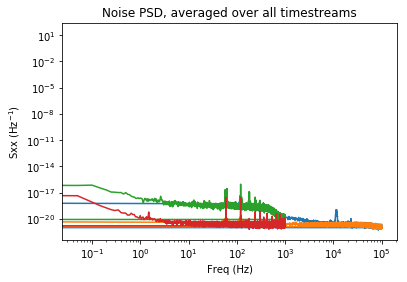

In [19]:
#psd_on1 = np.delete(psd_on1, 6, 1)
psd_on1mean = psd_on1.mean(axis=1)
psd_off1mean = psd_off1.mean(axis=1)
psd_fast = np.vstack((psd_onfreq1, psd_on1mean, psd_off1mean))

psd_on2mean = psd_on2.mean(axis=1)
psd_off2mean = psd_off2.mean(axis=1)

psd_slow = np.vstack((psd_onfreq2, psd_on2mean, psd_off2mean))

plt.plot(psd_fast[0,:],psd_fast[1,:])
plt.plot(psd_fast[0,:],psd_fast[2,:])
plt.plot(psd_slow[0,:], psd_slow[1,:])
plt.plot(psd_slow[0,:], psd_slow[2,:])
plt.semilogy()
plt.semilogx()
plt.xlabel('Freq (Hz)')
plt.ylabel('Sxx (Hz$^{-1}$)')
plt.title('Noise PSD, averaged over all timestreams')

np.savetxt(savedir+'PSDfast.txt', psd_fast)
np.savetxt(savedir+'PSDslow.txt', psd_slow)

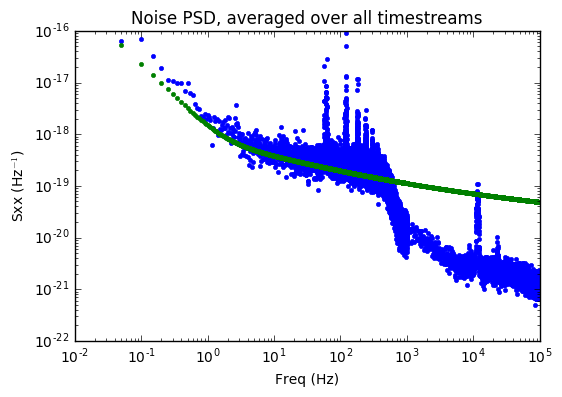

In [248]:
def func(x,A,B,n,C,tau, tau_f):
    return np.log10((A+B*x**(-n))/(1+(2*np.pi*np.log10(x)*tau)**2) + C )*(1/(1+(2*np.pi*np.log10(x)*tau_f)**2))
plt.plot(freqson, dataon,'.')
plt.plot(freqson, 10**func(freqson,5.e-19,1.e-18,1.5,3.e-21, 1.e-1, 1.e-6),'.')
plt.semilogy()
plt.semilogx()
plt.xlabel('Freq (Hz)')
plt.ylabel('Sxx (Hz$^{-1}$)')
plt.title('Noise PSD, averaged over all timestreams')

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]
24948 773


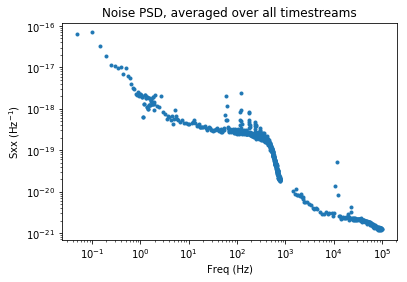

In [25]:
psd_fast_mask = np.where(psd_fast[0,:] > 1.e3)[0]
psd_slow_mask = np.where(psd_slow[0,:] > 0)[0]
freqson = np.hstack((psd_fast[0,psd_fast_mask],psd_slow[0,psd_slow_mask]))
dataon = np.hstack((psd_fast[1,psd_fast_mask],psd_slow[1,psd_slow_mask]))

bins = np.logspace(np.log10(1.e0),np.log10(1.e5),num=20)
lowfreqsindex = np.where(freqson <=2.0)[0]
newfreqson = freqson[lowfreqsindex]
newdataon = dataon[lowfreqsindex]
print (newfreqson)
for i in range(len(bins)-1):
    freqsinbin = np.where((freqson >= bins[i]) & (freqson < bins[i+1]))[0]
    if (len(freqsinbin) < 30) and (len(freqsinbin) > 0):
        newfreqson = np.append(newfreqson,freqson[freqsinbin])
        newdataon = np.append(newdataon,dataon[freqsinbin])        
    elif ((len(freqsinbin) >= 30) and (len(freqsinbin) < 100)):
        if np.all(np.diff(freqson[freqsinbin])>0):
            modfreqlist = np.log10(freqson[freqsinbin[:int(len(freqsinbin)/5)*5]])
            mod2freqlist = np.mean(modfreqlist.reshape(-1, 5), axis=1)
            moddata = np.log10(dataon[freqsinbin[:int(len(freqsinbin)/5)*5]])
            mod2data = np.mean(moddata.reshape(-1, 5), axis=1)
            newfreqson = np.append(newfreqson,10**(mod2freqlist))
            newdataon = np.append(newdataon,10**(mod2data))
        else:
            newfreqson = np.append(newfreqson,freqson[freqsinbin])
            newdataon = np.append(newdataon,dataon[freqsinbin])
    elif ((len(freqsinbin) >= 100) and (len(freqsinbin) < 200)):
        if np.all(np.diff(freqson[freqsinbin])>0):
            modfreqlist = np.log10(freqson[freqsinbin[:int(len(freqsinbin)/15)*15]])
            mod2freqlist = np.mean(modfreqlist.reshape(-1, 15), axis=1)
            moddata = np.log10(dataon[freqsinbin[:int(len(freqsinbin)/15)*15]])
            mod2data = np.mean(moddata.reshape(-1, 15), axis=1)
            newfreqson = np.append(newfreqson,10**(mod2freqlist))
            newdataon = np.append(newdataon,10**(mod2data))
    elif (len(freqsinbin) >= 200):
        if np.all(np.diff(freqson[freqsinbin])>0):
            modfreqlist = np.log10(freqson[freqsinbin[:int(len(freqsinbin)/30)*30]])
            mod2freqlist = np.mean(modfreqlist.reshape(-1, 30), axis=1)
            moddata = np.log10(dataon[freqsinbin[:int(len(freqsinbin)/30)*30]])
            mod2data = np.mean(moddata.reshape(-1, 30), axis=1)
            newfreqson = np.append(newfreqson,10**(mod2freqlist))
            newdataon = np.append(newdataon,10**(mod2data))
plt.clf()
plt.plot(newfreqson, newdataon,'.')
plt.semilogy()
plt.semilogx()
plt.xlabel('Freq (Hz)')
plt.ylabel('Sxx (Hz$^{-1}$)')
plt.title('Noise PSD, averaged over all timestreams')
print (len(freqson), len(newfreqson))

5.05e-19 2.5005000000000003e-18 1.5 2.5049999999999998e-21 0.001005 5.050000000000001e-06
4.423268310849585e-19 1.7699487952938685e-18 1.4438917376790308 2.599496464133392e-21 0.0006698135451987198 1.896601429051607e-06


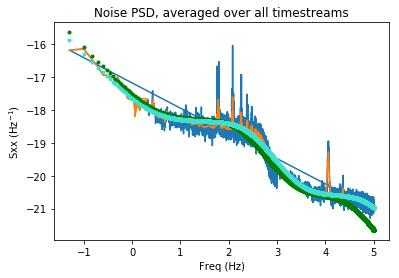

In [46]:
plt.plot(np.log10(freqson), np.log10(dataon))
plt.plot(np.log10(newfreqson), np.log10(newdataon))
#plt.semilogy()
#plt.semilogx()
plt.xlabel('Freq (Hz)')
plt.ylabel('Sxx (Hz$^{-1}$)')
plt.title('Noise PSD, averaged over all timestreams')

from scipy.optimize import curve_fit
def func(x,A,B,n,C,tau, tau_f):
    return ((A+B*x**(-n))/(1+(2*np.pi*x*tau)**2) + C )*(1/(1+(2*np.pi*x*tau_f)**2))
A,B,n,C, tau, tau_f = curve_fit(func, newfreqson, newdataon, bounds=([1.e-20,1.e-21,1,1.e-23,1.e-5,1.e-7], [1.e-18, 5.e-18,2.0, 5.e-21,2.e-3,1.e-5]))[0]
plt.plot(np.log10(freqson), np.log10(func(freqson,A,B,n,C, tau, tau_f)),'.', c='green')
print (A,B,n,C,tau,tau_f)

def func_log(x,A,B,n,C,tau, tau_f):
    return np.log10(((A+B*(10**x)**(-n))/(1+(2*np.pi*10**x*tau)**2) + C )*(1/(1+(2*np.pi*10**x*tau_f)**2)))
A,B,n,C, tau, tau_f = curve_fit(func_log, np.log10(newfreqson), np.log10(newdataon), bounds=([1.e-20,1.e-21,1,1.e-23,1.e-5,1.e-7], [1.e-18, 5.e-18,2.0, 5.e-21,2.e-3,1.e-5]))[0]
plt.plot(np.log10(freqson), func_log(np.log10(freqson),A,B,n,C, tau, tau_f),'.', c='turquoise')
print (A,B,n,C,tau,tau_f)

In [30]:
print(freqson)

[1020.   1040.   1060.   ...  999.85  999.9   999.95]


4.423268310849585e-19 1.7699487952938685e-18 1.4438917376790308 2.599496464133392e-21 0.0006698135451987198 1.896601429051607e-06


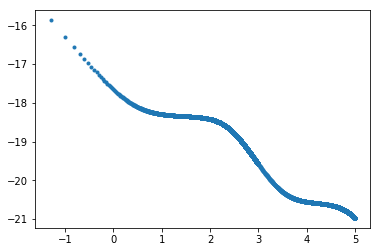

In [38]:
from scipy.optimize import curve_fit
def func(x,A,B,n,C,tau, tau_f):
    return np.log10(((A+B*(10**x)**(-n))/(1+(2*np.pi*10**x*tau)**2) + C )*(1/(1+(2*np.pi*10**x*tau_f)**2)))
A,B,n,C, tau, tau_f = curve_fit(func, np.log10(newfreqson), np.log10(newdataon), bounds=([1.e-20,1.e-21,1,1.e-23,1.e-5,1.e-7], [1.e-18, 5.e-18,2.0, 5.e-21,2.e-3,1.e-5]))[0]
plt.plot(np.log10(freqson), func(np.log10(freqson),A,B,n,C, tau, tau_f),'.')
print (A,B,n,C,tau,tau_f)

In [35]:
print(np.log(newdataon))

[-37.28376052 -37.20174783 -37.97820337 -38.48868969 -39.02253397
 -39.06087162 -39.16067394 -39.14361558 -39.53413597 -39.17976504
 -39.61707498 -39.71010994 -40.08146117 -40.29328668 -40.3265001
 -40.63996338 -40.69811895 -40.53068718 -40.7601947  -40.60523091
 -40.68303114 -40.81275896 -41.90259997 -41.1631904  -40.68657178
 -40.83849442 -41.32209143 -40.7816135  -41.4757613  -40.84447443
 -41.22758669 -41.23952299 -41.02756132 -40.89581445 -41.15800145
 -40.81499283 -41.18619818 -41.49870054 -41.05500385 -40.68604796
 -40.60523091 -40.68303114 -40.81275896 -41.90259997 -41.1631904
 -40.68657178 -40.83849442 -41.32209143 -40.7816135  -41.4757613
 -40.84447443 -41.22758669 -41.23952299 -41.02756132 -40.89581445
 -41.15800145 -40.81499283 -41.15272751 -41.30654436 -41.35247115
 -40.76110493 -41.64581773 -41.71659985 -42.0369877  -41.86762967
 -41.91349182 -42.07715662 -41.85797057 -42.30747206 -42.03524856
 -41.53836062 -41.86787494 -42.01732677 -42.06023457 -42.15428382
 -42.07026928